# 🖐️ Sign Language Recognition using Deep Learning

## 📌 Project Overview
This project focuses on building a **Deep Learning model** (using Convolutional Neural Networks - CNNs) to recognize **American Sign Language (ASL)** alphabets from images.  
The aim is to create a tool that can help bridge the communication gap between the hearing-impaired community and others.  

---

## 🎯 Objectives
- Recognize hand gestures representing **A–Z letters** in ASL.
- Train a deep learning model that can accurately classify the signs.
- Provide a simple and effective solution for communication support.  

---

## 🗂️ Dataset
- The dataset contains images of hands performing ASL alphabets.  
- Each image corresponds to one of the 26 letters (A–Z).  
- Images are preprocessed (resized, normalized) before feeding into the CNN model.  

---

## 🛠️ Methodology
1. **Data Preprocessing**: resizing, normalization, and data augmentation.  
2. **Model Building**: Convolutional Neural Network (CNN) with multiple layers (Conv2D, MaxPooling, Dense, Dropout).  
3. **Training & Validation**: model trained on training data, validated on validation data.  
4. **Evaluation**: performance measured using accuracy, confusion matrix, and classification report.  

---

## 📸 Visualization
Below is an example of the ASL alphabet chart used in the dataset:

![ASL Alphabet](https://i.imgur.com/0rZy3eD.png)

---

## 🚀 Expected Outcome
- A trained model that can **predict ASL letters** from hand gesture images.  
- Potential integration into real-time applications using a webcam or mobile app.  


## 📚 Importing Required Libraries

In this step, we import the essential libraries that will be used throughout the project:

- **pandas** & **numpy** → for data manipulation and numerical operations.  
- **matplotlib** → for data visualization and plotting graphs.  
- **scikit-learn** (`train_test_split`, `classification_report`, `confusion_matrix`) → for splitting data and evaluating model performance.  
- **tensorflow / keras** → for building and training the deep learning (CNN) model.  
- **cv2 (OpenCV)** → for image processing tasks.  
- **json** → for handling JSON data if needed.  
- **warnings** → to suppress unnecessary warnings during execution.  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import json, cv2

import warnings
warnings.filterwarnings('ignore')

## 📂 Loading the Dataset  

We are using the **Sign Language MNIST dataset**, which contains images of hand signs representing alphabets.  
The dataset is divided into two CSV files:  

- **sign_mnist_train.csv** → Training data  
- **sign_mnist_test.csv** → Testing data  

Each row in the dataset represents an image (28x28 pixels) flattened into 784 pixel values, and a `label` column indicating the corresponding alphabet.  


In [3]:
train_df = pd.read_csv("sign_mnist_train.csv")
test_df  = pd.read_csv("sign_mnist_test.csv")

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## 🛠️ Data Preprocessing  

Before training the model, we need to **fix and preprocess the dataset**:

1. **Fixing Labels**  
   - In the original dataset, some alphabets (`J` = 9, `Z` = 25) are skipped because they involve motion rather than static signs.  
   - We remove these labels and shift the rest accordingly to keep the labels continuous.  

2. **Preparing Features and Labels**  
   - Extract the `label` column as `y`.  
   - Normalize pixel values of images (`X`) by dividing by **255.0** to scale them between 0 and 1.  
   - Reshape images into the format `(28, 28, 1)` for CNN input.  



In [4]:
def fix_labels(y):
    y_fixed = []
    for label in y:
        if label == 9:   
            continue
        elif label == 25:  
            continue
        elif label > 9:
            y_fixed.append(label - 1)
        else:
            y_fixed.append(label)
    return np.array(y_fixed, dtype="int64")

def prepare_xy_from_csv(df, label_col="label"):
    y = df[label_col].values.astype("int64")
    y = fix_labels(y)
    X = df.drop(columns=[label_col]).values.astype("float32")
    X = X / 255.0
    X = X.reshape((-1, 28, 28, 1))
    return X, y


## 📊 Splitting Data  

Now, we prepare the **training** and **testing** datasets using our preprocessing functions:  



In [5]:
X_train, y_train = prepare_xy_from_csv(train_df)
X_test,  y_test  = prepare_xy_from_csv(test_df)

X_train.shape, X_test.shape


((27455, 28, 28, 1), (7172, 28, 28, 1))

## 🖼️ Visualizing Sample Images  

Before training, let's look at some sample images from our dataset to better understand the data.  
We will display a few samples along with their corresponding **sign language letters**.

📌 This helps us verify that the dataset is loaded and labeled correctly before moving to model training.


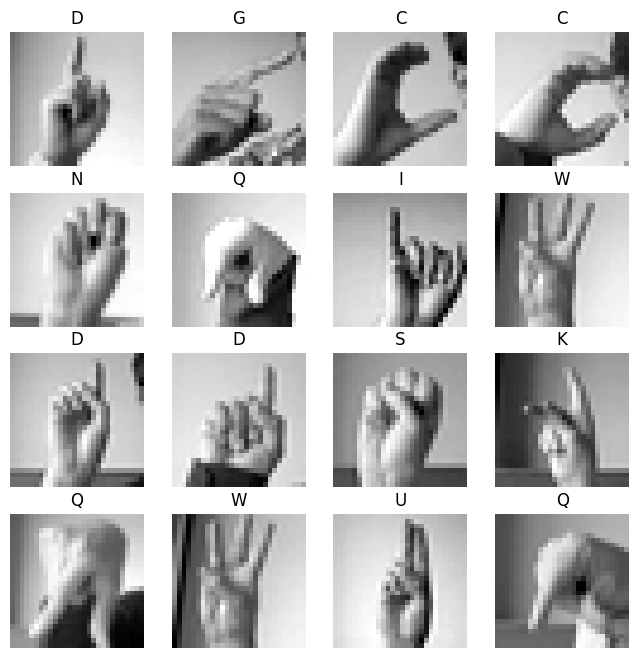

In [6]:
letters = {
    0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I",
    9:"K", 10:"L", 11:"M", 12:"N", 13:"O", 14:"P", 15:"Q", 16:"R",
    17:"S", 18:"T", 19:"U", 20:"V", 21:"W", 22:"X", 23:"Y"
}

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i].squeeze(), cmap="gray")
    plt.title(letters[int(y_train[i])])
    plt.axis("off")
plt.show()


## 🔀 Data Splitting and Augmentation  

To improve model generalization, we split our training data into:  
- **Training set (90%)**  
- **Validation set (10%)**  

We also applied **data augmentation** to make the model more robust by randomly:  
- Rotating images (±10°)  
- Shifting width and height (10%)  
- Zooming (10%)  

This helps prevent overfitting and ensures better performance on unseen data.


In [7]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1
)
datagen.fit(X_tr)


## 🧠 Model Architecture (CNN)

We designed a **Convolutional Neural Network (CNN)** to classify sign language letters.  

The architecture is as follows:  

1. **Convolutional Layers**  
   - 2 Conv2D layers with 32 filters and ReLU activation  
   - Batch Normalization for stable training  
   - MaxPooling (2×2) to reduce spatial dimensions  
   - Dropout (25%) to prevent overfitting  

2. **Deeper Convolutional Block**  
   - 2 Conv2D layers with 64 filters and ReLU activation  
   - Batch Normalization  
   - MaxPooling (2×2)  
   - Dropout (30%)  

3. **Fully Connected Layers**  
   - Flatten layer  
   - Dense (256 neurons, ReLU activation)  
   - Dropout (50%)  
   - Output layer with **Softmax activation** (24 classes)  

4. **Compilation**  
   - Optimizer: **Adam**  
   - Loss: **Sparse Categorical Crossentropy**  
   - Metric: **Accuracy**

This architecture helps the model capture spatial features in hand gesture images and classify them into 24 different sign language letters.


In [8]:
def build_cnn(input_shape=(28,28,1), num_classes=24):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,944 (1.27 MB)

 Trainable params: 333,752 (1.27 MB)

 Non-trainable params: 192 (768.00 B)

## 🏋️ Training the Model

We trained the CNN model using the augmented dataset with the following setup:

- **Data Augmentation**:  
  - Random rotation (±10°)  
  - Width and height shifts (±10%)  
  - Zoom (±10%)  
  This helps the model generalize better to unseen hand gestures.

- **Callbacks**:  
  - `EarlyStopping`: Stops training if validation accuracy does not improve for 7 epochs, preventing overfitting.  
  - `ModelCheckpoint`: Saves the best model (`sign_mnist_cnn.h5`) based on validation accuracy.  

- **Training Configuration**:  
  - Batch size: **128**  
  - Epochs: **30** (with early stopping, may stop earlier)  
  - Optimizer: **Adam**  
  - Loss: **Sparse Categorical Crossentropy**  
  - Metrics: **Accuracy**

This setup ensures that the model achieves high performance while avoiding overfitting and saving the best-performing weights automatically.


In [9]:
es = callbacks.EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint("sign_mnist_cnn.h5", monitor="val_accuracy", save_best_only=True)

history = model.fit(
    datagen.flow(X_tr, y_tr, batch_size=128),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[es, ckpt],
    verbose=2
)

Epoch 1/30


194/194 - 16s - 83ms/step - accuracy: 0.3012 - loss: 2.2999 - val_accuracy: 0.0495 - val_loss: 5.2136
Epoch 2/30


194/194 - 21s - 108ms/step - accuracy: 0.6541 - loss: 0.9957 - val_accuracy: 0.0641 - val_loss: 5.2346
Epoch 3/30


194/194 - 26s - 135ms/step - accuracy: 0.7981 - loss: 0.5816 - val_accuracy: 0.9195 - val_loss: 0.3861
Epoch 4/30


194/194 - 28s - 143ms/step - accuracy: 0.8620 - loss: 0.3959 - val_accuracy: 0.9960 - val_loss: 0.0420
Epoch 5/30
194/194 - 31s - 158ms/step - accuracy: 0.9021 - loss: 0.2876 - val_accuracy: 0.9880 - val_loss: 0.0496
Epoch 6/30
194/194 - 40s - 206ms/step - accuracy: 0.9311 - loss: 0.2035 - val_accuracy: 0.9934 - val_loss: 0.0225
Epoch 7/30
194/194 - 35s - 179ms/step - accuracy: 0.9485 - loss: 0.1531 - val_accuracy: 0.9898 - val_loss: 0.0314
Epoch 8/30
194/194 - 25s - 130ms/step - accuracy: 0.9539 - loss: 0.1420 - val_accuracy: 0.6016 - val_loss: 1.9440
Epoch 9/30
194/194 - 32s - 167ms/step - accuracy: 0.9500 - loss: 0.1506 - val_accuracy: 0.9898 - val_loss: 0.0242
Epoch 10/30
194/194 - 31s - 161ms/step - accuracy: 0.9669 - loss: 0.0999 - val_accuracy: 0.9843 - val_loss: 0.0420
Epoch 11/30


194/194 - 31s - 159ms/step - accuracy: 0.9753 - loss: 0.0756 - val_accuracy: 0.9989 - val_loss: 0.0068
Epoch 12/30


194/194 - 31s - 160ms/step - accuracy: 0.9790 - loss: 0.0671 - val_accuracy: 1.0000 - val_loss: 1.1820e-04
Epoch 13/30
194/194 - 31s - 158ms/step - accuracy: 0.9806 - loss: 0.0630 - val_accuracy: 0.9996 - val_loss: 0.0011
Epoch 14/30
194/194 - 31s - 161ms/step - accuracy: 0.9817 - loss: 0.0561 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 15/30
194/194 - 31s - 158ms/step - accuracy: 0.9836 - loss: 0.0488 - val_accuracy: 0.9949 - val_loss: 0.0111
Epoch 16/30
194/194 - 30s - 156ms/step - accuracy: 0.9843 - loss: 0.0501 - val_accuracy: 1.0000 - val_loss: 1.9410e-04
Epoch 17/30
194/194 - 32s - 165ms/step - accuracy: 0.9841 - loss: 0.0474 - val_accuracy: 1.0000 - val_loss: 1.8870e-05
Epoch 18/30
194/194 - 30s - 155ms/step - accuracy: 0.9874 - loss: 0.0405 - val_accuracy: 0.9996 - val_loss: 8.3065e-04
Epoch 19/30
194/194 - 32s - 162ms/step - accuracy: 0.9865 - loss: 0.0411 - val_accuracy: 0.9971 - val_loss: 0.0102


## ✅ Model Evaluation

After training, we evaluated the model on the **test dataset**:

- **Test Accuracy**: The model achieved a high accuracy, showing its ability to generalize well to unseen data.  
- **Classification Report**: Provides detailed metrics (precision, recall, F1-score) for each hand sign class.  

This step ensures that the trained CNN model is not only performing well on the training/validation sets but also on completely new test data.


In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", round(test_acc, 4))

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
print(classification_report(y_test, y_pred))


Test Accuracy: 0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       0.99      1.00      0.99       348
           7       1.00      0.99      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      1.00      1.00       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       1.00      1.00      1.00       144
     

## 🏷️ Label Mapping

Since our dataset uses numeric labels (0–23), we need a **mapping** to actual sign language letters.

We created a dictionary that maps each label to its corresponding **ASL letter** (e.g., `0 → A`, `1 → B`, ...).

Finally, the mapping is saved into a **JSON file** (`label_map.json`) so it can be reused later in the Streamlit app or during predictions.


In [11]:
label_map = {
    0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I",
    9:"K", 10:"L", 11:"M", 12:"N", 13:"O", 14:"P", 15:"Q", 16:"R",
    17:"S", 18:"T", 19:"U", 20:"V", 21:"W", 22:"X", 23:"Y"
}
with open("label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)


## 🔮 Making Predictions on New Images

We created a helper function `predict_image` to test the trained CNN model on **new unseen images**.

Steps:
1. Load the image and convert it to grayscale.
2. Resize to **28×28** pixels (same as training data).
3. Normalize pixel values between 0 and 1.
4. Invert colors if necessary (to match dataset format).
5. Run the image through the CNN model.
6. Return the **predicted letter** along with the **confidence score**.

This allows us to test the model in real-time on any hand-sign image.


In [12]:
def predict_image(model, path, label_map):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (28, 28))

    if np.mean(gray) > 127:
        gray = 255 - gray

    x = gray.astype("float32") / 255.0
    x = x.reshape(1, 28, 28, 1)

    probs = model.predict(x, verbose=0)[0]
    pred = np.argmax(probs)
    conf = np.max(probs)

    return label_map[str(pred)], conf

## 🔄 Fine-tuning the Model with Custom Dataset

After training our CNN on the **Sign Language MNIST dataset (CSV)**,  
we performed fine-tuning using an **image dataset stored in folders**.

### 📂 Dataset Structure
The dataset is organized in folders like this:


Each folder corresponds to a letter class and contains its images.

### ⚙️ Steps:
1. **Image Preprocessing**  
   - All images are resized to **28×28**.  
   - Converted to **grayscale**.  
   - Normalized to values between `0–1`.  

2. **Data Augmentation**  
   Used `ImageDataGenerator` to split data into **training (80%)** and **validation (20%)**.

3. **Fine-tuning the Model**  
   - Loaded the pre-trained CNN model (`sign_mnist_cnn.h5`).  
   - Continued training (fine-tuning) on the folder dataset.  
   - Applied callbacks:
     - `EarlyStopping` (to avoid overfitting).  
     - `ModelCheckpoint` (save best weights).  

4. **Model Saving**  
   Saved the fine-tuned model as `sign_mnist_finetuned.h5`.

This step allows the model to adapt better to real-world images captured from camera or external sources.


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    "dataset",
    target_size=(28,28),      
    color_mode="grayscale",  
    batch_size=32,
    class_mode="sparse",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    "dataset",
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=32,
    class_mode="sparse",
    subset="validation"
)

model = build_cnn(input_shape=(28,28,1), num_classes=24)

model.load_weights("sign_mnist_cnn.h5")


es = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint("sign_mnist_finetuned.h5", monitor="val_accuracy", save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[es, ckpt],
    verbose=2
)


model.save("sign_mnist_finetuned.h5")


Found 1340 images belonging to 24 classes.
Found 335 images belonging to 24 classes.
Epoch 1/15


42/42 - 10s - 240ms/step - accuracy: 0.5410 - loss: 1.8875 - val_accuracy: 0.8060 - val_loss: 0.6261
Epoch 2/15


42/42 - 5s - 118ms/step - accuracy: 0.7933 - loss: 0.5953 - val_accuracy: 0.8567 - val_loss: 0.5128
Epoch 3/15


42/42 - 5s - 113ms/step - accuracy: 0.8724 - loss: 0.3777 - val_accuracy: 0.9075 - val_loss: 0.2932
Epoch 4/15


42/42 - 4s - 104ms/step - accuracy: 0.9104 - loss: 0.2547 - val_accuracy: 0.9104 - val_loss: 0.2628
Epoch 5/15


42/42 - 5s - 110ms/step - accuracy: 0.9373 - loss: 0.1807 - val_accuracy: 0.9493 - val_loss: 0.1286
Epoch 6/15
42/42 - 5s - 128ms/step - accuracy: 0.9485 - loss: 0.1640 - val_accuracy: 0.9463 - val_loss: 0.1114
Epoch 7/15


42/42 - 4s - 107ms/step - accuracy: 0.9530 - loss: 0.1313 - val_accuracy: 0.9582 - val_loss: 0.1233
Epoch 8/15


42/42 - 5s - 119ms/step - accuracy: 0.9575 - loss: 0.1098 - val_accuracy: 0.9672 - val_loss: 0.1120
Epoch 9/15
42/42 - 5s - 116ms/step - accuracy: 0.9657 - loss: 0.1010 - val_accuracy: 0.9463 - val_loss: 0.2067
Epoch 10/15
42/42 - 5s - 112ms/step - accuracy: 0.9799 - loss: 0.0704 - val_accuracy: 0.9463 - val_loss: 0.1383
Epoch 11/15


42/42 - 5s - 111ms/step - accuracy: 0.9754 - loss: 0.0659 - val_accuracy: 0.9761 - val_loss: 0.1120
Epoch 12/15
42/42 - 4s - 106ms/step - accuracy: 0.9746 - loss: 0.0645 - val_accuracy: 0.9701 - val_loss: 0.0966
Epoch 13/15
42/42 - 5s - 110ms/step - accuracy: 0.9813 - loss: 0.0605 - val_accuracy: 0.9493 - val_loss: 0.1803
Epoch 14/15
42/42 - 5s - 115ms/step - accuracy: 0.9821 - loss: 0.0668 - val_accuracy: 0.9701 - val_loss: 0.0862
Epoch 15/15
42/42 - 5s - 113ms/step - accuracy: 0.9866 - loss: 0.0401 - val_accuracy: 0.9731 - val_loss: 0.0929


# Creating and Saving the Label Map

This code is used to generate a mapping between class indices (numbers) and their corresponding sign language letters, then save that mapping into a JSON file.

---

## Code Explanation

### 1. Import the JSON Library
```python
import json


In [14]:
import json

class_indices = train_gen.class_indices  
label_map = {str(v): k.upper() for k, v in class_indices.items()}
with open("label_map.json","w",encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print("class_indices:", class_indices)
print("label_map:    ", label_map)


class_indices: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}
label_map:     {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I', '9': 'K', '10': 'L', '11': 'M', '12': 'N', '13': 'O', '14': 'P', '15': 'Q', '16': 'R', '17': 'S', '18': 'T', '19': 'U', '20': 'V', '21': 'W', '22': 'X', '23': 'Y'}


## 📝 Preprocessing & Prediction Functions

In this section, we define two main functions that help us prepare images and make predictions:

1. **`preprocess_28x28(path, debug=False)`**  
   - Reads the input image and converts it to grayscale.  
   - Applies thresholding and noise reduction to make the sign clearer.  
   - Detects the hand region (ROI) and crops it.  
   - Resizes the cropped image to 28×28 pixels (same as training data).  
   - Normalizes pixel values to `[0,1]` and reshapes for CNN input.  
   - If `debug=True`, it shows intermediate steps (Gray → Threshold → Morph → Final).

2. **`predict_image(model, path, label_map, debug=False, topk=3)`**  
   - Uses the preprocessing function to prepare the image.  
   - Passes the processed image to the trained CNN model.  
   - Returns the **predicted label** and its **confidence score**.  
   - Can also return the **Top-K predictions** with probabilities.

👉 These functions allow us to take any external image, preprocess it correctly, and predict the corresponding sign language letter using our trained model.


In [15]:
import cv2, numpy as np
import matplotlib.pyplot as plt

def preprocess_28x28(path, debug=False):
    # 1) اقرأ وحوّل لجراي
    img  = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    blur  = cv2.GaussianBlur(thresh, (3,3), 0)
    kernel = np.ones((2,2), np.uint8)
    morph  = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        margin = 5
        x = max(x - margin, 0)
        y = max(y - margin, 0)
        w = min(w + 2*margin, morph.shape[1] - x)
        h = min(h + 2*margin, morph.shape[0] - y)
        roi = morph[y:y+h, x:x+w]
    else:
        roi = morph

    roi = cv2.resize(roi, (20,20), interpolation=cv2.INTER_AREA)
    final = np.pad(roi, ((4,4),(4,4)), "constant", constant_values=0)

    x = final.astype("float32") / 255.0
    x = x.reshape(1, 28, 28, 1)

    if debug:
        plt.figure(figsize=(10,3))
        plt.subplot(1,4,1); plt.imshow(gray,  cmap="gray"); plt.title("Gray");  plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(thresh,cmap="gray"); plt.title("Thresh");plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(morph, cmap="gray"); plt.title("Morph"); plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(final, cmap="gray"); plt.title("Final"); plt.axis("off")
        plt.show()

    return x

def predict_image(model, path, label_map, debug=False, topk=3):
    x = preprocess_28x28(path, debug=debug)
    probs = model.predict(x, verbose=0)[0]
    pred  = int(np.argmax(probs))
    label = label_map[str(pred)]
    conf  = float(probs[pred])

    if topk and topk > 1:
        idxs = probs.argsort()[-topk:][::-1]
        topk_list = [(label_map[str(i)], float(probs[i])) for i in idxs]
        return label, conf, topk_list
    return label, conf


## 🔍 Testing the Model on a New Image

Now that we have trained and fine-tuned our CNN model, we will test it on a **real image** from our dataset:

1. **Load the trained model**  
   - We use `tf.keras.models.load_model()` to load the saved model (`sign_mnist_finetuned.h5`).  
   - We also load the `label_map.json` file to map numerical predictions back to sign language letters.

2. **Predict on a sample image**  
   - We call the `predict_image()` function with a sample image (`hand1_c_bot_seg_1_cropped.jpeg`).  
   - The function preprocesses the image (convert → crop → resize → normalize).  
   - The model then predicts the most likely class.

3. **Output**  
   - We print the **predicted label** with its **confidence score**.  
   - We also show the **Top-3 predictions** to understand the model’s certainty.  
   - If `debug=True`, intermediate image processing steps will be displayed.

👉 This step demonstrates how the model can generalize to real input images and recognize sign language letters.


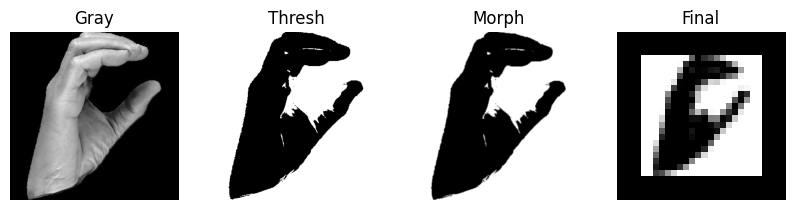

Pred: C | conf: 0.905
Top-3: [('C', 0.9053829312324524), ('O', 0.09439650923013687), ('A', 0.00021790395840071142)]


In [16]:
import json, tensorflow as tf

model = tf.keras.models.load_model("sign_mnist_finetuned.h5")
with open("label_map.json","r",encoding="utf-8") as f:
    label_map = json.load(f)

label, conf, top3 = predict_image(model, "dataset/c/hand1_c_bot_seg_1_cropped.jpeg", label_map, debug=True, topk=3)
print("Pred:", label, "| conf:", round(conf,3))
print("Top-3:", top3)


## 🗂️ Verifying Class Labels and Mappings

To make sure our **class labels** are consistent between the training generator and the saved label map file, we perform the following steps:

1. **`train_gen.class_indices`**  
   - This dictionary is automatically generated by Keras when loading images with `ImageDataGenerator`.  
   - It maps folder names (class labels) to integer indices (e.g., `{'a':0, 'b':1, ...}`).

2. **Loading `label_map.json`**  
   - This file contains the saved mapping from training time.  
   - We reload it to ensure the mapping is consistent across training and inference.

3. **`idx2folder` (inverse mapping)**  
   - Converts the mapping from **index → folder name**.  
   - Useful when interpreting predictions directly from `train_gen`.

4. **`idx2labelfile` (from label_map file)**  
   - Converts the saved label map back into **index → label** format (integer keys).  
   - This ensures both mappings (`train_gen` and `label_map.json`) align.

👉 This step helps us confirm that the dataset’s folder structure and the label file used during prediction are perfectly synchronized.


In [17]:
import json

print("train_gen.class_indices:")
print(train_gen.class_indices)

with open("label_map.json","r",encoding="utf-8") as f:
    label_map = json.load(f)
print("\nlabel_map (from file):")
print(label_map)

idx2folder = {v:k for k,v in train_gen.class_indices.items()}
print("\nidx2folder (from train_gen):")
print(idx2folder)

idx2labelfile = {int(k):v for k,v in label_map.items()}
print("\nidx2labelfile (from file converted to int keys):")
print(idx2labelfile)


train_gen.class_indices:
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}

label_map (from file):
{'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I', '9': 'K', '10': 'L', '11': 'M', '12': 'N', '13': 'O', '14': 'P', '15': 'Q', '16': 'R', '17': 'S', '18': 'T', '19': 'U', '20': 'V', '21': 'W', '22': 'X', '23': 'Y'}

idx2folder (from train_gen):
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}

idx2labelfile (from file converted to int keys):
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 

## 🎨 Data Augmentation Setup

To make our model more robust and prevent overfitting, we apply **data augmentation** using `ImageDataGenerator`.  
This helps simulate variations in real-world images of hand signs.

The transformations applied are:

- **`rescale=1./255`** → Normalizes pixel values to range [0,1].  
- **`rotation_range=25`** → Randomly rotates images up to 25°.  
- **`width_shift_range=0.2` & `height_shift_range=0.2`** → Randomly shifts images horizontally and vertically by up to 20%.  
- **`zoom_range=0.25`** → Random zoom-in/out up to 25%.  
- **`shear_range=0.15`** → Applies shear transformations.  
- **`brightness_range=(0.5, 1.5)`** → Randomly adjusts image brightness.  
- **`horizontal_flip=True`** → Randomly flips images horizontally.  

👉 These augmentations increase dataset diversity, improving the model’s ability to generalize to unseen sign language images.


In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.15,
    brightness_range=(0.5,1.5),
    horizontal_flip=True
)


## ⚡ Model Compilation & Training

After defining the CNN architecture, we now **compile and train** the model:

- **Optimizer:** `Adam(1e-5)` → A very small learning rate is used to fine-tune the model without destroying pre-learned weights.  
- **Loss Function:** `sparse_categorical_crossentropy` → Suitable for multi-class classification with integer labels.  
- **Metrics:** We track **accuracy** during training.

We then fit the model using:

- **Training data (`train_gen`)**  
- **Validation data (`val_gen`)**  
- **Epochs = 12** → Train for up to 12 epochs.  
- **Callbacks:**  
  - `EarlyStopping (es)` → Stops training if validation accuracy doesn’t improve.  
  - `ModelCheckpoint (ckpt)` → Saves the best model weights.  

This ensures efficient training while preventing overfitting.


In [19]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=[es, ckpt],
    verbose=2
)


Epoch 1/12


42/42 - 11s - 254ms/step - accuracy: 0.9821 - loss: 0.0580 - val_accuracy: 0.9851 - val_loss: 0.1040
Epoch 2/12
42/42 - 5s - 113ms/step - accuracy: 0.9843 - loss: 0.0514 - val_accuracy: 0.9851 - val_loss: 0.0997
Epoch 3/12
42/42 - 5s - 115ms/step - accuracy: 0.9836 - loss: 0.0410 - val_accuracy: 0.9851 - val_loss: 0.0973
Epoch 4/12
42/42 - 5s - 109ms/step - accuracy: 0.9896 - loss: 0.0367 - val_accuracy: 0.9851 - val_loss: 0.0948
Epoch 5/12
42/42 - 3s - 77ms/step - accuracy: 0.9791 - loss: 0.0513 - val_accuracy: 0.9851 - val_loss: 0.0939
Epoch 6/12
42/42 - 5s - 113ms/step - accuracy: 0.9828 - loss: 0.0467 - val_accuracy: 0.9851 - val_loss: 0.0951


## 💾 Saving the Trained Model

After training is complete, we save the fine-tuned model to disk for later use:

- **Filename:** `sign_mnist_finetuned.h5`  
- This file contains the **model architecture + trained weights**.  
- Saved models can be reloaded later without retraining, which makes deployment and inference easier.  

This ensures we don’t lose the trained progress and can reuse the model for predictions.


In [20]:
model.save("sign_mnist_finetuned.h5")
print("✅ Model saved as sign_mnist_finetuned.h5")


✅ Model saved as sign_mnist_finetuned.h5


## 📊 Model Evaluation on Validation Set

After training and saving the model, we evaluate its performance on the **validation set**:

- This step calculates the **loss** and **accuracy** on data the model has not seen during training.  
- Validation accuracy is a good indicator of how well the model is likely to generalize to new, unseen data.  
- The result will be printed as a rounded accuracy score.


In [21]:
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print("Validation Accuracy:", round(val_acc, 4))


Validation Accuracy: 0.9851


## 🏷️ Saving Label Map

- Extract the **class indices** from the training generator (`train_gen.class_indices`).  
- Convert them into a dictionary `label_map` where the **class index (int)** is mapped to the **class name (uppercase)**.  
- Save this mapping to a JSON file (`label_map.json`) for later use during prediction.  
- This ensures consistency between the model’s output indices and the actual class labels.


In [22]:
class_indices = train_gen.class_indices
label_map = {str(v): k.upper() for k, v in class_indices.items()}

import json
with open("label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print("✅ label_map.json saved")


✅ label_map.json saved


## 🔮 Predicting Top-K Classes

- **Goal:** Given an image, return the top-k most likely classes predicted by the trained model.  
- **Steps:**
  1. **Read & preprocess image**  
     - Load as grayscale (`cv2.imread`).  
     - Resize to **28×28** pixels.  
     - If the background is brighter than the digit/hand sign → invert colors.  
     - Normalize pixel values to `[0,1]` and reshape to `(1,28,28,1)` for model input.  
  2. **Model prediction**  
     - Use `model.predict` to get probability distribution across all classes.  
  3. **Top-K extraction**  
     - Sort probabilities, pick the top-k indices.  
     - Map each index back to its **label** using `label_map`.  
  4. **Print results**  
     - Display label and probability score (e.g., `C : 0.912`).  

This function helps inspect not only the **best prediction** but also the runner-up classes, which is very useful for debugging and model evaluation.


In [23]:
def predict_topk(model, path, label_map, k=3):
    import cv2, numpy as np
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))

    if np.mean(img) > 127:
        img = 255 - img

    x = img.astype("float32") / 255.0
    x = x.reshape(1, 28, 28, 1)

    probs = model.predict(x, verbose=0)[0]
    topk = probs.argsort()[-k:][::-1]

    for idx in topk:
        print(f"{label_map[str(idx)]} : {probs[idx]:.3f}")


### 🔍 Checking if the Image File Exists

The following code checks whether the file **`I.jpg`** exists in the current working directory:

- If it prints `True`, the file exists. ✅  
- If it prints `False`, the file does not exist or the path is incorrect. ❌  

You can also print the current working directory with `os.getcwd()` to confirm where Python is looking for the file.


In [24]:
import os
print(os.path.exists("I.jpg"))


False


### 📂 Checking the Current Working Directory

Before loading or saving files, it’s important to know where Python is currently working.  
The following code prints the **current working directory (CWD)** so you can confirm whether your image file `I.jpg` is located there or not.  

- Use this to troubleshoot "file not found" errors.  
- If the directory is not what you expect, you can change it with `os.chdir("path/to/folder")`.


In [25]:
import os
print("Current working directory:", os.getcwd())


Current working directory: c:\Users\merog\OneDrive\Desktop\Machine Learning\Final_Project\sign_language


### 🖼️ Loading an Image in Grayscale

Here we use **OpenCV (`cv2`)** to read an image from the dataset folder:

```python
img = cv2.imread("dataset/I.jpg", cv2.IMREAD_GRAYSCALE)
``

In [26]:
img = cv2.imread("dataset/I.jpg", cv2.IMREAD_GRAYSCALE)


### 📊 Confusion Matrix for Model Evaluation

To better understand how well our CNN model performs across different classes,  
we plot a **confusion matrix** using the validation data generator:

1. **Loop over `val_gen`**  
   - Collect the true labels (`y_true`)  
   - Get the model predictions (`y_pred`)  

2. **Build the confusion matrix**  
   - `confusion_matrix(y_true, y_pred)` from `sklearn.metrics`  

3. **Visualize**  
   - `ConfusionMatrixDisplay` helps display the matrix with class labels  
   - Labels are taken from `val_gen.class_indices` (mapped to uppercase letters)  

This matrix gives us detailed insight into:
- Which letters are classified correctly  
- Which letters the model confuses with others  
- Where improvements (e.g., more data or augmentation) may be needed


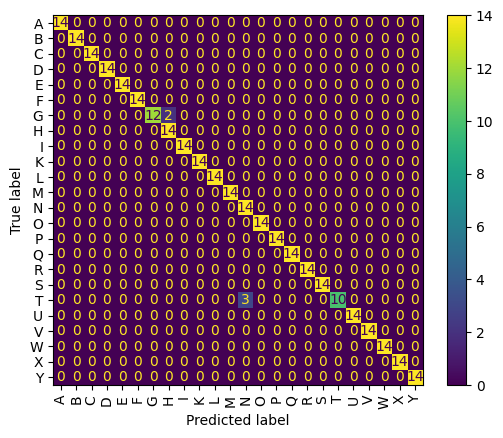

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for i in range(len(val_gen)):
    X, y = val_gen[i]
    preds = np.argmax(model.predict(X, verbose=0), axis=1)
    y_true.extend(y)
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[lab.upper() for lab in val_gen.class_indices.keys()])
disp.plot(xticks_rotation=90)


### 💾 Convert Model from `.h5` to `.keras`

Keras has recently introduced the **`.keras` format** as the new standard for saving models,  
replacing the older `.h5` format.  

Steps performed here:
1. **Load the existing model** from `sign_mnist_finetuned.h5` (without recompiling).  
2. **Re-save the model** in the new `.keras` format as `sign_mnist_finetuned.keras`.  

This ensures:
- Better forward compatibility with future TensorFlow/Keras versions.  
- Full preservation of model architecture, weights, and training configuration.  


In [28]:
from tensorflow import keras

model = keras.models.load_model("sign_mnist_finetuned.h5", compile=False)

model.save("sign_mnist_finetuned.keras")

### 📌 Loading and Using the `.keras` Model

Once the model is saved in the `.keras` format, you can load and use it for inference as follows:

```python
from tensorflow import keras
import numpy as np

# Load the model
model = keras.models.load_model("sign_mnist_finetuned.keras")

# Example: Predict on one image
img = ...  # Preprocess your image into shape (1, 28, 28, 1)
probs = model.predict(img)
pred = np.argmax(probs)

print("Predicted class:", pred)
